# A community-based test for bilateral symmetry

## Preliminaries

In [1]:

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import remove_shared_ax, rotate_labels
from graspologic.utils import binarize
from matplotlib.transforms import Bbox
from myst_nb import glue
from pkg.data import (
    load_maggot_graph,
    load_network_palette,
    load_node_palette,
    select_nice_nodes,
)
from pkg.io import savefig
from pkg.perturb import remove_edges
from pkg.plot import set_theme
from pkg.stats import stochastic_block_test
from seaborn.utils import relative_luminance
from tqdm import tqdm


def stashfig(name, **kwargs):
    foldername = "sbm_test"
    savefig(name, foldername=foldername, **kwargs)

/Users/bpedigo/JHU_code/bilateral/.venv/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.List[numpy.ndarray] deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/Users/bpedigo/JHU_code/bilateral/.venv/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.List[scipy.sparse.csr.csr_matrix] deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/Users/bpedigo/JHU_code/bilateral/.venv/lib/python3.9/site-packages/beartype/_util

## Load and process data

In [2]:

t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()


GROUP_KEY = "simple_group"

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
left_mg, right_mg = mg.bisect(lcc=True)
left_nodes = left_mg.nodes
right_nodes = right_mg.nodes

left_adj = left_mg.sum.adj
right_adj = right_mg.sum.adj
left_adj = binarize(left_adj)
right_adj = binarize(right_adj)

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

Removed 12 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## Run the stochastic block model 2-sample test

In [3]:

stat, pvalue, misc = stochastic_block_test(
    left_adj, right_adj, labels1=left_labels, labels2=right_labels, method="fisher"
)
glue("uncorrected_pvalue", pvalue)

5.471371901948314e-05

### Plot the results
The plot below describes:
- The estimated community-to-community connection probabilities for both the left and the right hemisphere,
- The number of nodes in each community
- The p-values for each individual test

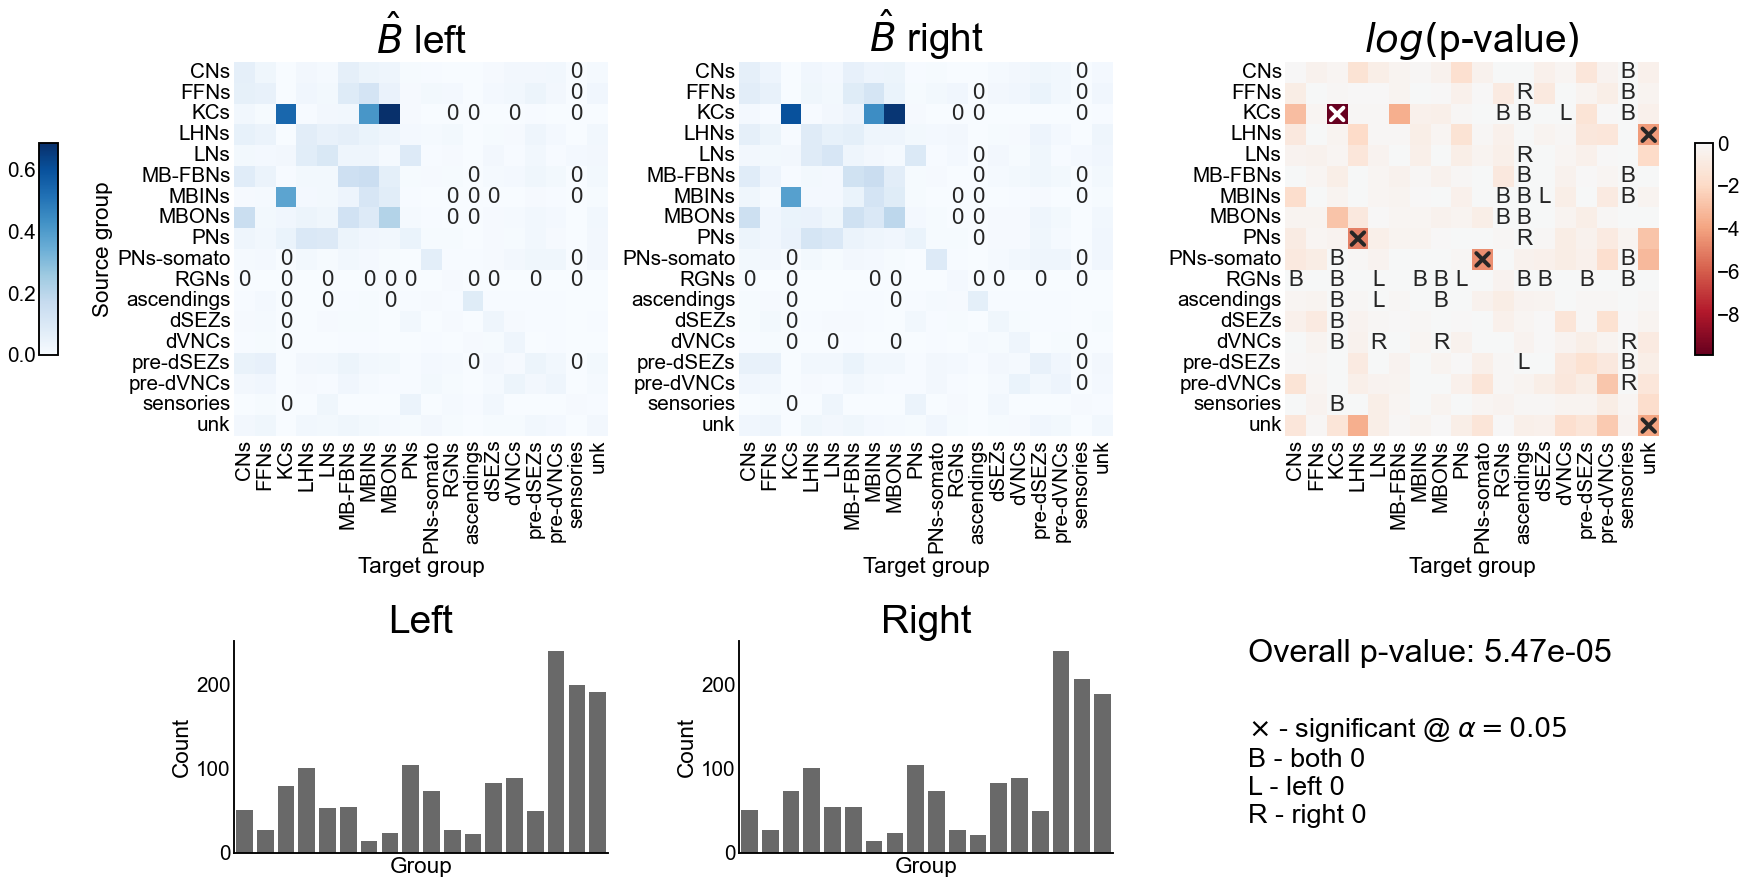

In [4]:
# get values
B1 = misc["probabilities1"]
B2 = misc["probabilities2"]
index = B1.index
p_max = max(B1.values.max(), B2.values.max())
uncorrected_pvalues = misc["uncorrected_pvalues"]
n_tests = misc["n_tests"]
K = B1.shape[0]
alpha = 0.05
hb_thresh = alpha / n_tests

# set up plot
pad = 2
width_ratios = [0.5, pad + 0.8, 10, pad - 0.4, 10, pad + 0.7, 10, 0.5]
height_ratios = [2, 0.4, 1]
set_theme(font_scale=1.25)
fig, axs = plt.subplots(
    len(height_ratios),
    len(width_ratios),
    figsize=(30, 15),
    gridspec_kw=dict(
        height_ratios=height_ratios,
        width_ratios=width_ratios,
    ),
)
left_col = 2
right_col = 4
pvalue_col = 6
top_row = 0
bottom_row = 2


heatmap_kws = dict(cmap="Blues", square=True, cbar=False, vmax=p_max, fmt="s")

# heatmap of left connection probabilities
annot = np.full((K, K), "")
annot[B1.values == 0] = 0
ax = axs[top_row, left_col]
ax.sharex(axs[bottom_row, left_col])
sns.heatmap(B1, ax=ax, annot=annot, **heatmap_kws)
ax.set(ylabel="Source group", xlabel="Target group")
ax.set_title(r"$\hat{B}$ left", fontsize="xx-large")


# heatmap of right connection probabilities
annot = np.full((K, K), "")
annot[B2.values == 0] = 0
ax = axs[top_row, right_col]
im = sns.heatmap(B2, ax=ax, annot=annot, **heatmap_kws)
ax.set(ylabel="", xlabel="Target group")
ax.set_title(r"$\hat{B}$ right", fontsize="xx-large")


# handle the colorbars
# NOTE: did it this way cause the other options weren't playing nice with auto constrain
# layouts.


def shrink_axis(ax, scale=0.7):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [[pos.xmin, mid - scale * 0.5 * height], [pos.xmax, mid + scale * 0.5 * height]]
    )
    ax.set_position(new_pos)


ax = axs[top_row, 0]
shrink_axis(ax, scale=0.5)
cbar = fig.colorbar(
    im.get_children()[0],
    cax=ax,
    fraction=1,
    shrink=1,
    ticklocation="left",
)


# plot p-values
ax = axs[top_row, pvalue_col]

colors = im.get_children()[0].get_facecolors()
significant = uncorrected_pvalues < hb_thresh


annot = np.full((K, K), "")
annot[(B1.values == 0) & (B2.values == 0)] = "B"
annot[(B1.values == 0) & (B2.values != 0)] = "L"
annot[(B1.values != 0) & (B2.values == 0)] = "R"
plot_pvalues = np.log10(uncorrected_pvalues)
plot_pvalues[np.isnan(plot_pvalues)] = 0
im = sns.heatmap(
    plot_pvalues,
    ax=ax,
    annot=annot,
    cmap="RdBu",
    center=0,
    square=True,
    cbar=False,
    fmt="s",
)
ax.set(ylabel="", xlabel="Target group")
ax.set(xticks=np.arange(K) + 0.5, xticklabels=index)
ax.set_title(r"$log($p-value$)$", fontsize="xx-large")

# NOTE: the x's looked bad so I did this super hacky thing...
pad = 0.2
for idx, (is_significant, color) in enumerate(zip(significant.values.ravel(), colors)):
    if is_significant:
        i, j = np.unravel_index(idx, (K, K))
        # REF: seaborn heatmap
        lum = relative_luminance(color)
        text_color = ".15" if lum > 0.408 else "w"

        xs = [j + pad, j + 1 - pad]
        ys = [i + pad, i + 1 - pad]
        ax.plot(xs, ys, color=text_color, linewidth=4)
        xs = [j + 1 - pad, j + pad]
        ys = [i + pad, i + 1 - pad]
        ax.plot(xs, ys, color=text_color, linewidth=4)

# plot colorbar for the pvalue plot
# NOTE: only did it this way for consistency with the other colorbar
ax = axs[top_row, 7]
shrink_axis(ax, scale=0.5)
cbar = fig.colorbar(
    im.get_children()[0],
    cax=ax,
    fraction=1,
    shrink=1,
    ticklocation="right",
)


# plot the counts in each group
def countplot(group_counts, ax):
    for i in range(len(group_counts)):
        ax.bar(i + 0.5, group_counts[i], color="dimgray")
    ax.set(ylabel="Count", xlabel="Group", xticks=[])


# left
ax = axs[bottom_row, left_col]
countplot(misc["group_counts1"], ax)
ax.set_title("Left", fontsize="xx-large")
remove_shared_ax(ax, y=False)
axs[top_row, left_col].set_xticks(np.arange(K) + 0.5)
axs[top_row, left_col].set_xticklabels(index)

# right
ax = axs[bottom_row, right_col]
ax.sharex(axs[top_row, right_col])
countplot(misc["group_counts2"], ax)
ax.set_title("Right", fontsize="xx-large")
remove_shared_ax(ax, y=False)
axs[top_row, right_col].set_xticks(np.arange(K) + 0.5)
axs[top_row, right_col].set_xticklabels(index)

# some text to describe the overall p-values and legend
ax = axs[bottom_row, pvalue_col]
ax.axis("off")
ax.text(-0.1, 0.9, f"Overall p-value: {pvalue:0.2e}", fontsize="x-large", ha="left")
ax.text(
    -0.1,
    0.65,
    r"$\times$ - significant @ "
    + r"$ \alpha=0.05$"
    + "\n"
    + "B - both 0\n"
    + "L - left 0\n"
    + "R - right 0\n",
    va="top",
    fontsize="large",
)


for i in range(len(height_ratios)):
    for j in range(len(width_ratios)):
        if not axs[i, j].has_data() and not (i == bottom_row and j == pvalue_col):
            axs[i, j].set_visible(False)

stashfig("SBM-left-right-comparison")

We see that the p-value for this test is
```{glue:} uncorrected_pvalue
```
indicating that we should reject our null hypothesis that the communitiy connection
probabilities are the same.

In [5]:
# # %% [markdown]
# # ## Look at the community connections that were significantly different

# #%%
# row_inds, col_inds = np.nonzero(significant.values)

# n_significant = len(row_inds)

# rows = []
# for row_ind, col_ind in zip(row_inds, col_inds):
#     source = index[row_ind]
#     target = index[col_ind]
#     left_p = B1.loc[source, target]
#     right_p = B2.loc[source, target]
#     pair = source + r"$\rightarrow$" + target
#     rows.append(
#         {
#             "source": source,
#             "target": target,
#             "p": left_p,
#             "side": "Left",
#             "pair": pair,
#         }
#     )
#     rows.append(
#         {
#             "source": source,
#             "target": target,
#             "p": right_p,
#             "side": "Right",
#             "pair": pair,
#         }
#     )
# sig_data = pd.DataFrame(rows)

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.pointplot(
#     data=sig_data,
#     y="p",
#     x="pair",
#     ax=ax,
#     hue="side",
#     dodge=True,
#     join=False,
#     palette=network_palette,
# )

# ax.get_legend().set_title("Side")
# rotate_labels(ax)
# ax.set(xlabel="Group pair", ylabel="Connection probability")
# stashfig("significant-p-comparison")

# #%% [markdown]
# # ## Resample the right network to make the density the same, rerun the test
# #%%
# n_edges_left = np.count_nonzero(left_adj)
# n_edges_right = np.count_nonzero(right_adj)
# n_remove = n_edges_right - n_edges_left
# glue("n_edges_left", n_edges_left, display=False)
# glue("n_edges_right", n_edges_right, display=False)
# glue("n_remove", n_remove, display=False)

# rows = []
# n_resamples = 100
# glue("n_resamples", n_resamples, display=False)
# for i in tqdm(range(n_resamples)):
#     subsampled_right_adj = remove_edges(
#         right_adj, effect_size=n_remove, random_seed=rng
#     )
#     stat, pvalue, misc = stochastic_block_test(
#         left_adj,
#         subsampled_right_adj,
#         labels1=left_labels,
#         labels2=right_labels,
#         method="fisher",
#     )
#     rows.append({"stat": stat, "pvalue": pvalue, "misc": misc, "resample": i})

# resample_results = pd.DataFrame(rows)

# #%% [markdown]
# # ### Plot the p-values for the corrected tests
# #%%
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.histplot(data=resample_results, x="pvalue", ax=ax)
# ax.set(xlabel="p-value", ylabel="", yticks=[])
# ax.spines["left"].set_visible(False)
# stashfig("p-values-post-correction")

# mean_resample_pvalue = np.mean(resample_results["pvalue"])
# median_resample_pvalue = np.median(resample_results["pvalue"])

# #%% [markdown]
# # ## End
# #%%
# elapsed = time.time() - t0
# delta = datetime.timedelta(seconds=elapsed)
# print("----")
# print(f"Script took {delta}")
# print(f"Completed at {datetime.datetime.now()}")
# print("----")